In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Ridge
import math
from itertools import zip_longest
import random
from feature_selection import get_elastic_importances, get_lasso_importances, get_anova_importances
from collections import defaultdict
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import Pipeline
#to get rid of the warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
#data
data = pd.read_csv('Fish3.txt', delimiter=' ')
# print('data head:', data.head())
print("data shape: ", data.shape)
X = data.drop('Species', axis=1)
print("X.head", X.head())
target = data['Species']
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

# X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=seed)
# print("X_train shape:" , X.shape)
# print(X.iloc[0])
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)
# X_train = (X_train - mean) / std
# X_test = (X_test - mean) / std


data shape:  (1866, 7)
X.head        Weight         L1         L2         L3     Height      Width
1  170.530305  19.323169  22.913269  23.887829  25.233577  14.826372
2  493.721354  28.299621  31.028229  34.917027  37.856243  13.675772
3   33.657735  17.435741  18.072636  23.489747  26.765675  13.660683
4  584.259843  32.491349  33.126297  39.298082  37.610853  13.622560
5  970.375723  37.122510  39.817489  42.473488  29.878001  17.403387


In [4]:

def get_new_name(n):
    names = [f"L{i}" for i in range(4, 4 + n)]
    return names

In [5]:
# create a banch of uncorrelated features for the data set

def get_uncorrelated_features(original_data, unrelated_features_num):
    new_X = original_data.copy()  
    feature_names = get_new_name(unrelated_features_num)
    for i in range(unrelated_features_num):
        random_feature_column = np.random.rand(original_data.shape[0]).reshape(-1,1)
        new_X = np.hstack((new_X, random_feature_column))
        
    return feature_names, new_X 

new_feature_names, new_X = get_uncorrelated_features(X, 12)


original_feature_names = ['Weight', 'L1', 'L2', 'L3', 'Height', 'Width']
all_feature_names = original_feature_names + new_feature_names
df_extended_uncorrelated = pd.DataFrame(new_X, columns=all_feature_names)

print("X shape after adding correlated features: ", new_X.shape)

X shape after adding correlated features:  (1866, 18)


add correlated featrues to the data: 

In [6]:
def get_correlated_features(original_data):
    new_X = original_data.copy()
    feature_names = get_new_name(original_data.shape[1]*2)
    
    new_feature_list = []
    for i, column_name in enumerate(original_data.columns):
        
        square_feature_column = np.square(original_data[column_name])
        if i % 2 == 0:
            feature_column = np.sqrt(np.maximum(original_data[column_name], 0))
        else:
            feature_column = np.log(original_data[column_name] + 1e-3)
        new_feature_list.append(feature_column)
        new_feature_list.append(square_feature_column)
    
    new_features = np.column_stack(new_feature_list)
    new_X = np.hstack((original_data.values, new_features))
    return new_X, feature_names


new_X, new_feature_names = get_correlated_features(X)

all_feature_names = original_feature_names + new_feature_names
df_extended_correlated = pd.DataFrame(new_X, columns=all_feature_names)



In [7]:
# function for classifers and their performances
def get_classifiers_perfomance(data, data_target):
    
    classifiers = {
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'KNN-10': KNeighborsClassifier(n_neighbors=10),
        'SVM-Polynomial': SVC(kernel='poly', degree=3)
    }

    all_results_all_metrics = []
    for seed in range(5): 
        X_train, X_test, target_train, target_test = train_test_split(data, data_target, test_size=0.3, random_state=seed)
        
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        results = {}

        for name, clf in classifiers.items():
            pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
            y_pred = cross_val_predict(pipeline, X_train, target_train, cv=cv)
            
            report = classification_report(target_train, y_pred, output_dict=True)
            results[name] = {}
            # confusion = confusion_matrix(target_train, y_pred)
            # results[name]['mean_f1'] = report['macro avg']['f1-score']
            for class_label in ['Bream', 'Perch', 'Pike', 'Roach', 'SilverBream', 'Smelt', 'Whitewish']:
                results[name][f'{class_label}_f1'] = report[class_label]["f1-score"]
            
            print(f'{name} Results: {results[name]}')
            
        all_results_all_metrics.append(results)
    
    return all_results_all_metrics

In [8]:
# funciton for selection methods: 

seed= 42
def get_anova_importances(X_data, y_data) -> np.ndarray:
    f_values, _ = f_classif(X_data, y_data)
    return f_values

def get_lasso_importances(X_data, y_data, l1=0.1, seed=None) -> np.ndarray:
    lasso_logreg = LogisticRegression(penalty="l1", solver='liblinear', random_state=seed, C=1/l1)
    lasso_logreg.fit(X_data, y_data)
    importances = np.mean(np.abs(lasso_logreg.coef_), axis=0)
    return importances

def get_elastic_importances(X_data, y_data, l1=0.1, l2=0.1, seed=None) -> np.ndarray:
    elastic_logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1, C=1/l2, random_state=seed)
    elastic_logreg.fit(X_data, y_data)
    importances = np.mean(np.abs(elastic_logreg.coef_), axis=0)
    return importances

def selection_feature_method(data, data_target):
    print(data)
    
    X_train, X_test, target_train, target_test = train_test_split(data, data_target, test_size=0.3, random_state=seed)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std


    features = list(X_train.columns)
    X_train = pd.DataFrame(X_train, columns=features)
    X_test = pd.DataFrame(X_test, columns=features)

    num_folds = 10
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    lasso_means = []
    elastic_means = []


    # Get importances from cross-validation
    for train_index, test_index in skf.split(X_train, target_train):
        X_fold, y_fold = X_train.iloc[train_index], target_train.iloc[train_index]
        # Apply feature selection methods
        selected_lasso = get_lasso_importances(X_fold, y_fold, seed=42)
        selected_elastic = get_elastic_importances(X_fold, y_fold, seed=42)
        
        lasso_means.append(selected_lasso)
        elastic_means.append(selected_elastic)
        
    # Convert means to arrays
    lasso_means = np.array(lasso_means)
    elastic_means = np.array(elastic_means)

    # Normalize importances
    lasso_means = lasso_means / lasso_means.max(axis=1)[:, np.newaxis]
    elastic_means = elastic_means / elastic_means.max(axis=1)[:, np.newaxis]

    # Calculate means and standard deviations
    lasso_means_mean = lasso_means.mean(axis=0)
    lasso_means_std = lasso_means.std(axis=0)
    elastic_means_mean = elastic_means.mean(axis=0)
    elastic_means_std = elastic_means.std(axis=0)

    # Store results in dictionary
    features_dict = {}
    for i, feature in enumerate(features):
        features_dict[feature] = {
            "cv_lasso_values": lasso_means_mean[i],
            "cv_lasso_std": lasso_means_std[i],
            "cv_elastic_values": elastic_means_mean[i],
            "cv_elastic_std": elastic_means_std[i],
        }
    return features_dict

Correlated features and Uncorelated feature data for classificaitons methods:

In [9]:
correlated_classifiers_result = get_classifiers_perfomance(df_extended_correlated, target)
uncorrelated_classifiers_result = get_classifiers_perfomance(df_extended_uncorrelated, target)

RandomForest Results: {'Bream_f1': 0.9503722084367245, 'Perch_f1': 0.8289738430583501, 'Pike_f1': 0.9817073170731707, 'Roach_f1': 0.7549668874172185, 'SilverBream_f1': 0.9627329192546584, 'Smelt_f1': 0.9863013698630136, 'Whitewish_f1': 0.6153846153846154}
KNN-10 Results: {'Bream_f1': 0.9486858573216521, 'Perch_f1': 0.8158995815899581, 'Pike_f1': 0.9847094801223242, 'Roach_f1': 0.7697368421052632, 'SilverBream_f1': 0.9693251533742331, 'Smelt_f1': 0.9829351535836177, 'Whitewish_f1': 0.7058823529411765}
SVM-Polynomial Results: {'Bream_f1': 0.9258777633289987, 'Perch_f1': 0.5614973262032086, 'Pike_f1': 0.9847094801223242, 'Roach_f1': 0.5016501650165016, 'SilverBream_f1': 0.9235294117647059, 'Smelt_f1': 0.9863013698630136, 'Whitewish_f1': 0.27053140096618356}
RandomForest Results: {'Bream_f1': 0.9424083769633508, 'Perch_f1': 0.837782340862423, 'Pike_f1': 0.9798270893371758, 'Roach_f1': 0.7682119205298014, 'SilverBream_f1': 0.9715909090909091, 'Smelt_f1': 0.9833887043189369, 'Whitewish_f1': 

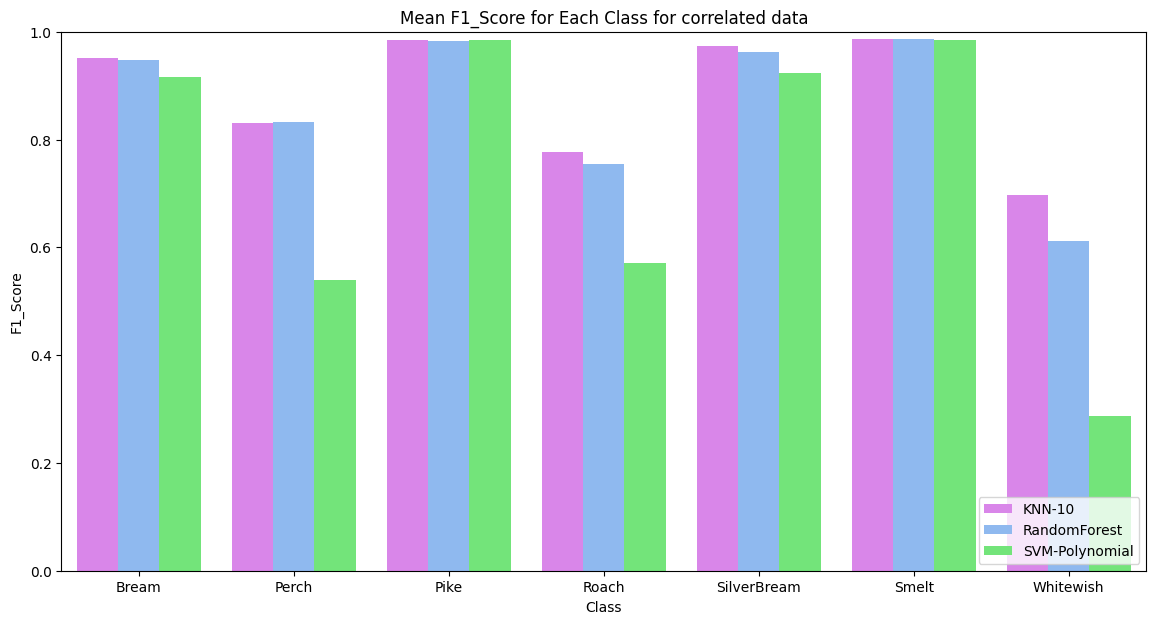

In [10]:
# Initialize lists to store results
f1_list = []
colors = ['#E475FA', '#7FB7FF','#60F769']
# , '#4354FF','#2BD336', '#FD6317', 
# Extract specificities and sensitivities from all_results
for seed, results in enumerate(correlated_classifiers_result):
    for name, metrics in results.items():
        for class_label in ['Bream', 'Perch', 'Pike', 'Roach', 'SilverBream', 'Smelt', 'Whitewish']:
            f1_list.append({
                'Seed': seed,
                'Classifier': name,
                'Class': class_label,
                'F1_Score': metrics[f'{class_label}_f1']
            })

# Convert lists to DataFrames
f1_df = pd.DataFrame(f1_list)

# Calculate mean specificity and sensitivity for each class and classifier
mean_f1 = f1_df.groupby(['Classifier', 'Class'])['F1_Score'].mean().reset_index()


 #plot the f1 performance 
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='F1_Score', hue='Classifier', data=mean_f1, palette=colors)
plt.title('Mean F1_Score for Each Class for correlated data')
plt.xlabel('Class')
plt.ylabel('F1_Score')
plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show() 




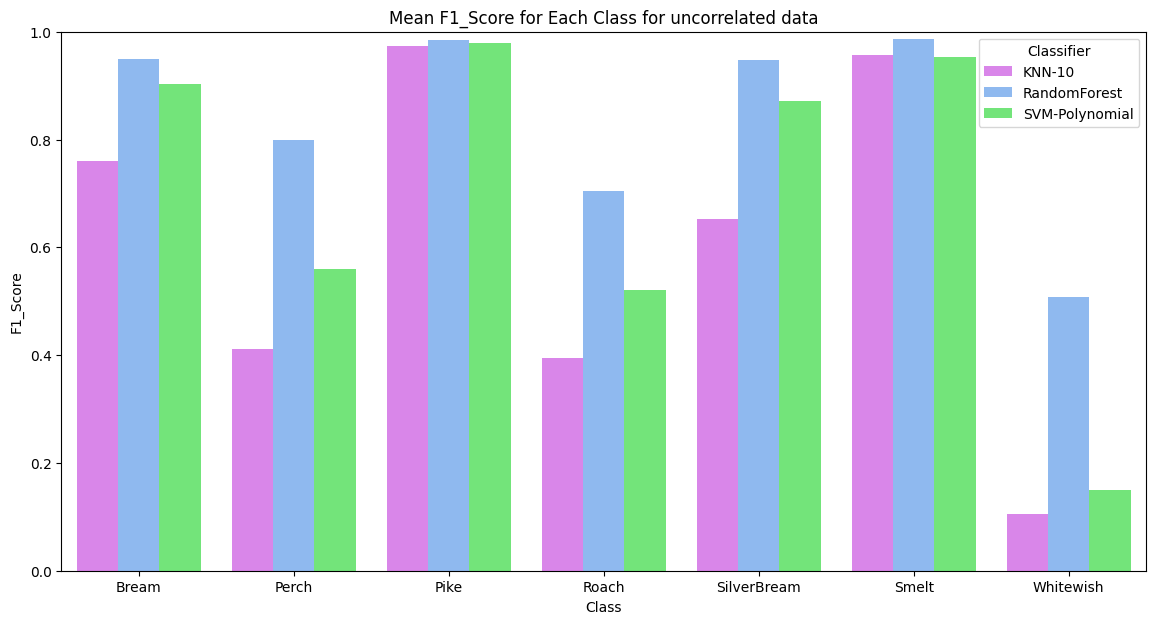

In [11]:
# Initialize lists to store results
f1_list = []
# Extract specificities and sensitivities from all_results
for seed, results in enumerate(uncorrelated_classifiers_result):
    for name, metrics in results.items():
        for class_label in ['Bream', 'Perch', 'Pike', 'Roach', 'SilverBream', 'Smelt', 'Whitewish']:
            f1_list.append({
                'Seed': seed,
                'Classifier': name,
                'Class': class_label,
                'F1_Score': metrics[f'{class_label}_f1']
            })

# Convert lists to DataFrames
f1_df = pd.DataFrame(f1_list)

# Calculate mean specificity and sensitivity for each class and classifier
mean_f1 = f1_df.groupby(['Classifier', 'Class'])['F1_Score'].mean().reset_index()


 #plot the f1 performance 
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='F1_Score', hue='Classifier', data=mean_f1, palette=colors)
plt.title('Mean F1_Score for Each Class for uncorrelated data')
plt.xlabel('Class')
plt.ylabel('F1_Score')
plt.ylim(0,1.0)
# plt.legend(loc='lower right')
plt.show() 




Correlated features and uncorelated features for selection methods:

In [12]:
correlated_feature_importances = selection_feature_method(df_extended_correlated, target)
uncorrelated_feature_importances = selection_feature_method(df_extended_uncorrelated, target)


          Weight         L1         L2         L3     Height      Width  \
0     170.530305  19.323169  22.913269  23.887829  25.233577  14.826372   
1     493.721354  28.299621  31.028229  34.917027  37.856243  13.675772   
2      33.657735  17.435741  18.072636  23.489747  26.765675  13.660683   
3     584.259843  32.491349  33.126297  39.298082  37.610853  13.622560   
4     970.375723  37.122510  39.817489  42.473488  29.878001  17.403387   
...          ...        ...        ...        ...        ...        ...   
1861  233.883001  21.472337  23.214813  26.442944  40.784288  14.765249   
1862  723.303811  44.358968  46.711126  48.576242  14.273842  10.595850   
1863   33.663332  17.808868  19.376625  19.997247  25.880671  13.286945   
1864  191.334807  19.593163  18.977962  25.113758  40.999351  12.884869   
1865  240.603320  22.116440  25.535806  30.319068  39.933240  13.500233   

             L4             L5        L6           L7        L8           L9  \
0     13.058725   2

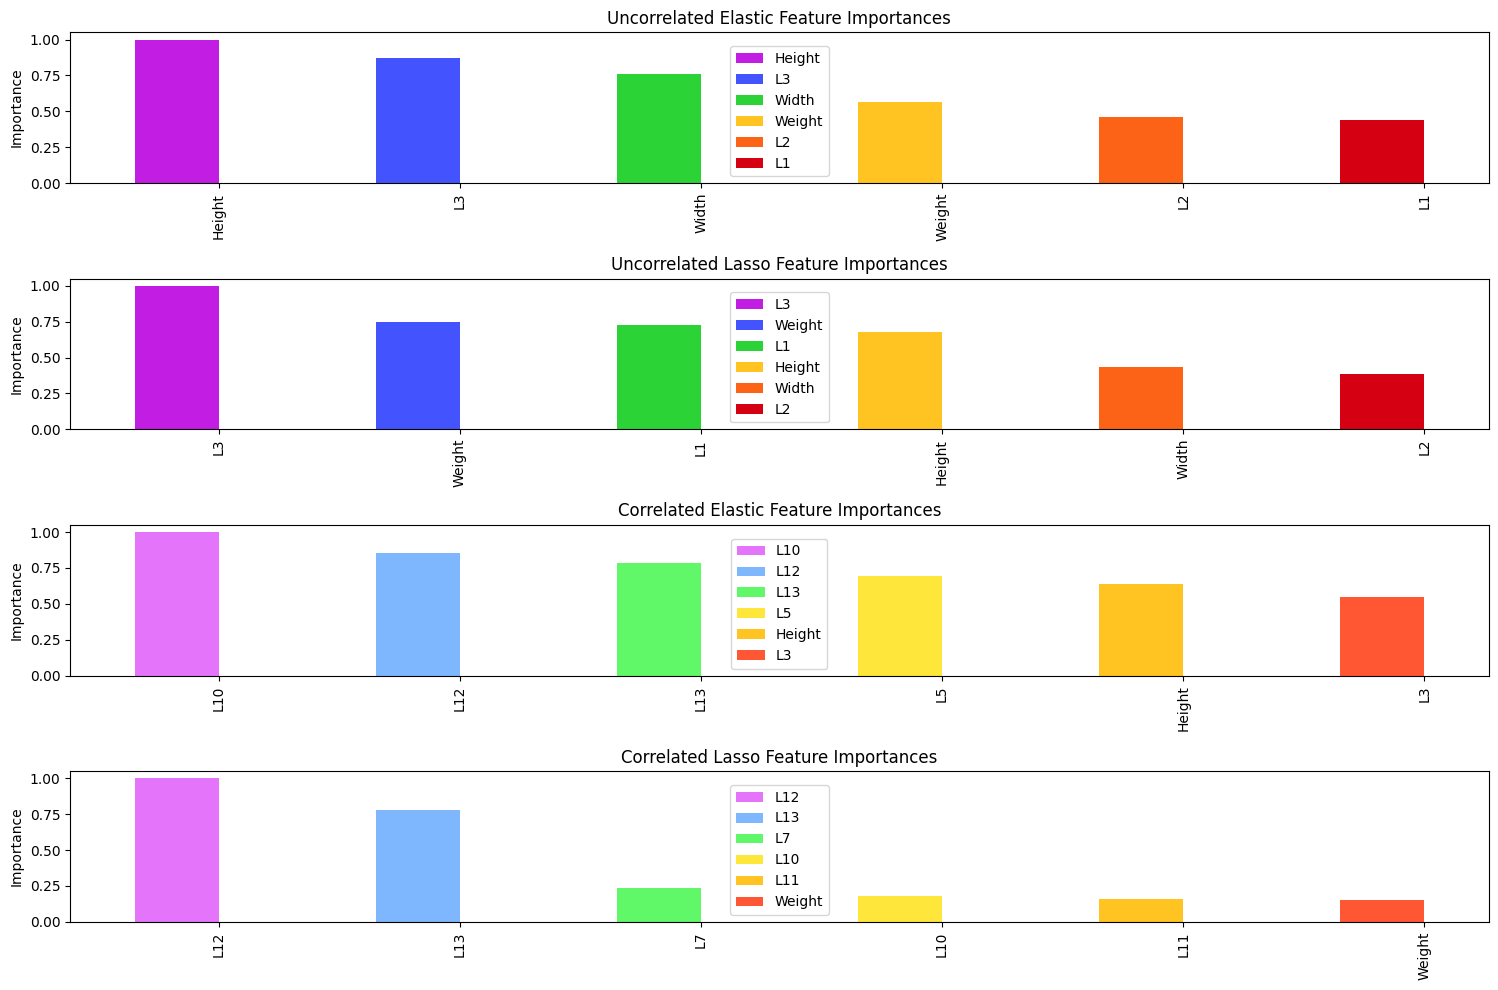

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming correlated_feature_importances and uncorrelated_feature_importances are defined somewhere above
# Assuming df_extended_correlated is defined somewhere above

features = list(df_extended_correlated.columns)
features_range = np.arange(len(features))

# Define the width of the bars
bar_width = 0.35  

# Colors for the bars
colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']
colors1 = ['#E475FA', '#7FB7FF','#60F769', '#FEE73A', '#FFC322', '#FF5733']

top_correlated_features_lasso = sorted(correlated_feature_importances, key=lambda x: correlated_feature_importances[x]['cv_lasso_values'], reverse=True)[:6]
top_uncorrelated_features_lasso = sorted(uncorrelated_feature_importances, key=lambda x: uncorrelated_feature_importances[x]['cv_lasso_values'], reverse=True)[:6]
top_correlated_features_elastic = sorted(correlated_feature_importances, key=lambda x: correlated_feature_importances[x]['cv_elastic_values'], reverse=True)[:6]
top_uncorrelated_features_elastic = sorted(uncorrelated_feature_importances, key=lambda x: uncorrelated_feature_importances[x]['cv_elastic_values'], reverse=True)[:6]

plt.figure(figsize=(15, 10))

# Uncorrelated Elastic Net
plt.subplot(4, 1, 1)
for i, feature in enumerate(top_uncorrelated_features_elastic):
    plt.bar(i - bar_width/2, uncorrelated_feature_importances[feature]["cv_elastic_values"], bar_width, color=colors[i % len(colors)], label=feature if i < len(colors) else "")
plt.xticks(np.arange(len(top_uncorrelated_features_elastic)), top_uncorrelated_features_elastic, rotation='vertical')
plt.title("Uncorrelated Elastic Feature Importances")
plt.ylabel("Importance")
if len(top_uncorrelated_features_elastic) <= len(colors):
    plt.legend()

# Uncorrelated Lasso
plt.subplot(4, 1, 2)
for i, feature in enumerate(top_uncorrelated_features_lasso):
    plt.bar(i - bar_width/2, uncorrelated_feature_importances[feature]["cv_lasso_values"], bar_width, color=colors[i % len(colors)], label=feature if i < len(colors) else "")
plt.xticks(np.arange(len(top_uncorrelated_features_lasso)), top_uncorrelated_features_lasso, rotation='vertical')
plt.title("Uncorrelated Lasso Feature Importances")
plt.ylabel("Importance")
if len(top_uncorrelated_features_lasso) <= len(colors):
    plt.legend()

# Correlated Elastic Net
plt.subplot(4, 1, 3)
for i, feature in enumerate(top_correlated_features_elastic):
    plt.bar(i - bar_width/2, correlated_feature_importances[feature]["cv_elastic_values"], bar_width, color=colors1[i % len(colors1)], label=feature if i < len(colors1) else "")
plt.xticks(np.arange(len(top_correlated_features_elastic)), top_correlated_features_elastic, rotation='vertical')
plt.title("Correlated Elastic Feature Importances")
plt.ylabel("Importance")
if len(top_correlated_features_elastic) <= len(colors1):
    plt.legend()

# Correlated Lasso
plt.subplot(4, 1, 4)
for i, feature in enumerate(top_correlated_features_lasso):
    plt.bar(i - bar_width/2, correlated_feature_importances[feature]["cv_lasso_values"], bar_width, color=colors1[i % len(colors1)], label=feature if i < len(colors1) else "")
plt.xticks(np.arange(len(top_correlated_features_lasso)), top_correlated_features_lasso, rotation='vertical')
plt.title("Correlated Lasso Feature Importances")
plt.ylabel("Importance")
if len(top_correlated_features_lasso) <= len(colors1):
    plt.legend()

plt.tight_layout()
plt.show()
